# 오버워치 2 점수판 분석 AI

In [1]:
import pandas as pd
from os import path
import joblib

players = 10


def prepare_scoreboards(defeat_, victory_):
    scoreboards_ = pd.concat([defeat_, victory_])
    scoreboards_.set_index(
        pd.Index((i, j) for i in range(len(scoreboards_.index) // players) for j in range(players)), inplace=True
    )
    return scoreboards_


datapath = path.join('datasets', '')
range_ = range(2, 9)
defeat = pd.read_csv(datapath + 'role_defeat.csv', usecols=range_)
victory = pd.read_csv(datapath + 'role_victory.csv', usecols=range_)
scoreboards = prepare_scoreboards(defeat, victory)
d_max = scoreboards['D'].max()
joblib.dump(d_max, 'max.joblib')
scoreboards.loc[
    (
            scoreboards['E'] == 0
    ) & (
            scoreboards['A'] == 0
    ) & (
            scoreboards['D'] == 0
    ) & (
            scoreboards['DMG'] == 0
    ) & (
            scoreboards['H'] == 0
    ) & (
            scoreboards['MIT'] == 0
    ), 'D'
] = d_max
scoreboards

E   A   D    DMG      H    MIT    GAME
0   0   1   1   4   3453      0   2466  DEFEAT
    1   1   0   3   2146      0      0  DEFEAT
    2   0   0   5   2273    648      0  DEFEAT
    3   2   0   4    513   2366    640  DEFEAT
    4   0   1   3      0   3977      0  DEFEAT
...    ..  ..  ..    ...    ...    ...     ...
799 5  27   7   8  15849      0  15230  DEFEAT
    6  29   3   8  16346   2157      0  DEFEAT
    7  26   1   8  12135      0    750  DEFEAT
    8  19  21   8   5391  12042   4184  DEFEAT
    9  13  18  12   3535  10878    641  DEFEAT

[8000 rows x 7 columns]

In [2]:
scoreboards.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 8000 entries, (0, 0) to (799, 9)
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   E       8000 non-null   int64 
 1   A       8000 non-null   int64 
 2   D       8000 non-null   int64 
 3   DMG     8000 non-null   int64 
 4   H       8000 non-null   int64 
 5   MIT     8000 non-null   int64 
 6   GAME    8000 non-null   object
dtypes: int64(6), object(1)
memory usage: 499.9+ KB


In [3]:
scoreboards.describe()

,E,A,D,DMG,H,MIT
count,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000
mean,14.461000,7.345125,6.549125,6804.842125,3800.866875,2278.685875
std,9.289175,8.060716,3.802091,4449.841810,4969.075712,4382.926625
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.000000,1.000000,4.000000,3299.750000,0.000000,0.000000
50%,14.000000,4.000000,6.000000,6128.000000,720.000000,381.500000
75%,20.000000,12.000000,9.000000,9663.750000,7237.750000,1934.750000
max,58.000000,62.000000,23.000000,29922.000000,26419.000000,41849.000000


In [4]:
import matplotlib as mpl
import os
import matplotlib.pyplot as plt

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
IMAGES_PATH = path.join('.', 'images')
os.makedirs(IMAGES_PATH, exist_ok=True)


def save_fig(fig_id, tight_layout=True, fig_extension='png', resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + '.' + fig_extension)
    print('그림 저장:' + fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, dpi=resolution, format=fig_extension)

In [5]:
scoreboards

E   A   D    DMG      H    MIT    GAME
0   0   1   1   4   3453      0   2466  DEFEAT
    1   1   0   3   2146      0      0  DEFEAT
    2   0   0   5   2273    648      0  DEFEAT
    3   2   0   4    513   2366    640  DEFEAT
    4   0   1   3      0   3977      0  DEFEAT
...    ..  ..  ..    ...    ...    ...     ...
799 5  27   7   8  15849      0  15230  DEFEAT
    6  29   3   8  16346   2157      0  DEFEAT
    7  26   1   8  12135      0    750  DEFEAT
    8  19  21   8   5391  12042   4184  DEFEAT
    9  13  18  12   3535  10878    641  DEFEAT

[8000 rows x 7 columns]

In [6]:
tank = pd.concat([scoreboards[::players], scoreboards[5::players]])
damage = pd.concat([scoreboards[1::players], scoreboards[2::players], scoreboards[6::players], scoreboards[7::players]])
support = pd.concat(
    [scoreboards[3::players], scoreboards[4::players], scoreboards[8::players], scoreboards[9::players]]
)

In [7]:
tank.describe()

,E,A,D,DMG,H,MIT
count,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000
mean,18.164375,4.398750,6.310625,9755.981250,503.754375,9179.623125
std,9.674366,3.613919,3.713523,4244.823189,1238.985621,5741.863676
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,11.000000,2.000000,4.000000,6630.750000,0.000000,5030.250000
50%,18.000000,4.000000,6.000000,9399.000000,0.000000,8035.000000
75%,24.000000,6.000000,8.000000,12437.750000,401.000000,12115.000000
max,58.000000,28.000000,23.000000,27480.000000,15168.000000,41849.000000


In [8]:
damage.describe()

,E,A,D,DMG,H,MIT
count,3200.000000,3200.000000,3200.000000,3200.000000,3200.000000,3200.000000
mean,17.513125,2.003125,7.239687,8752.959375,296.293437,594.763438
std,8.971586,2.569689,4.018446,3873.319872,513.231918,1040.394387
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,11.000000,0.000000,4.000000,5906.750000,0.000000,0.000000
50%,17.000000,1.000000,7.000000,8363.500000,0.000000,108.500000
75%,23.000000,3.000000,10.000000,11111.000000,418.000000,781.250000
max,56.000000,16.000000,23.000000,29922.000000,3353.000000,12145.000000


In [9]:
support.describe()

,E,A,D,DMG,H,MIT
count,3200.000000,3200.000000,3200.000000,3200.000000,3200.000000,3200.000000
mean,9.557187,14.160312,5.977812,3381.155313,8953.996563,512.139688
std,6.946802,8.365867,3.503378,2371.781495,4052.660399,833.847898
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.000000,8.000000,3.000000,1694.000000,6027.250000,0.000000
50%,9.000000,13.000000,6.000000,3003.500000,8516.500000,222.000000
75%,14.000000,19.000000,8.000000,4618.000000,11446.250000,669.250000
max,48.000000,62.000000,23.000000,15946.000000,26419.000000,7778.000000


그림 저장:tank_hist


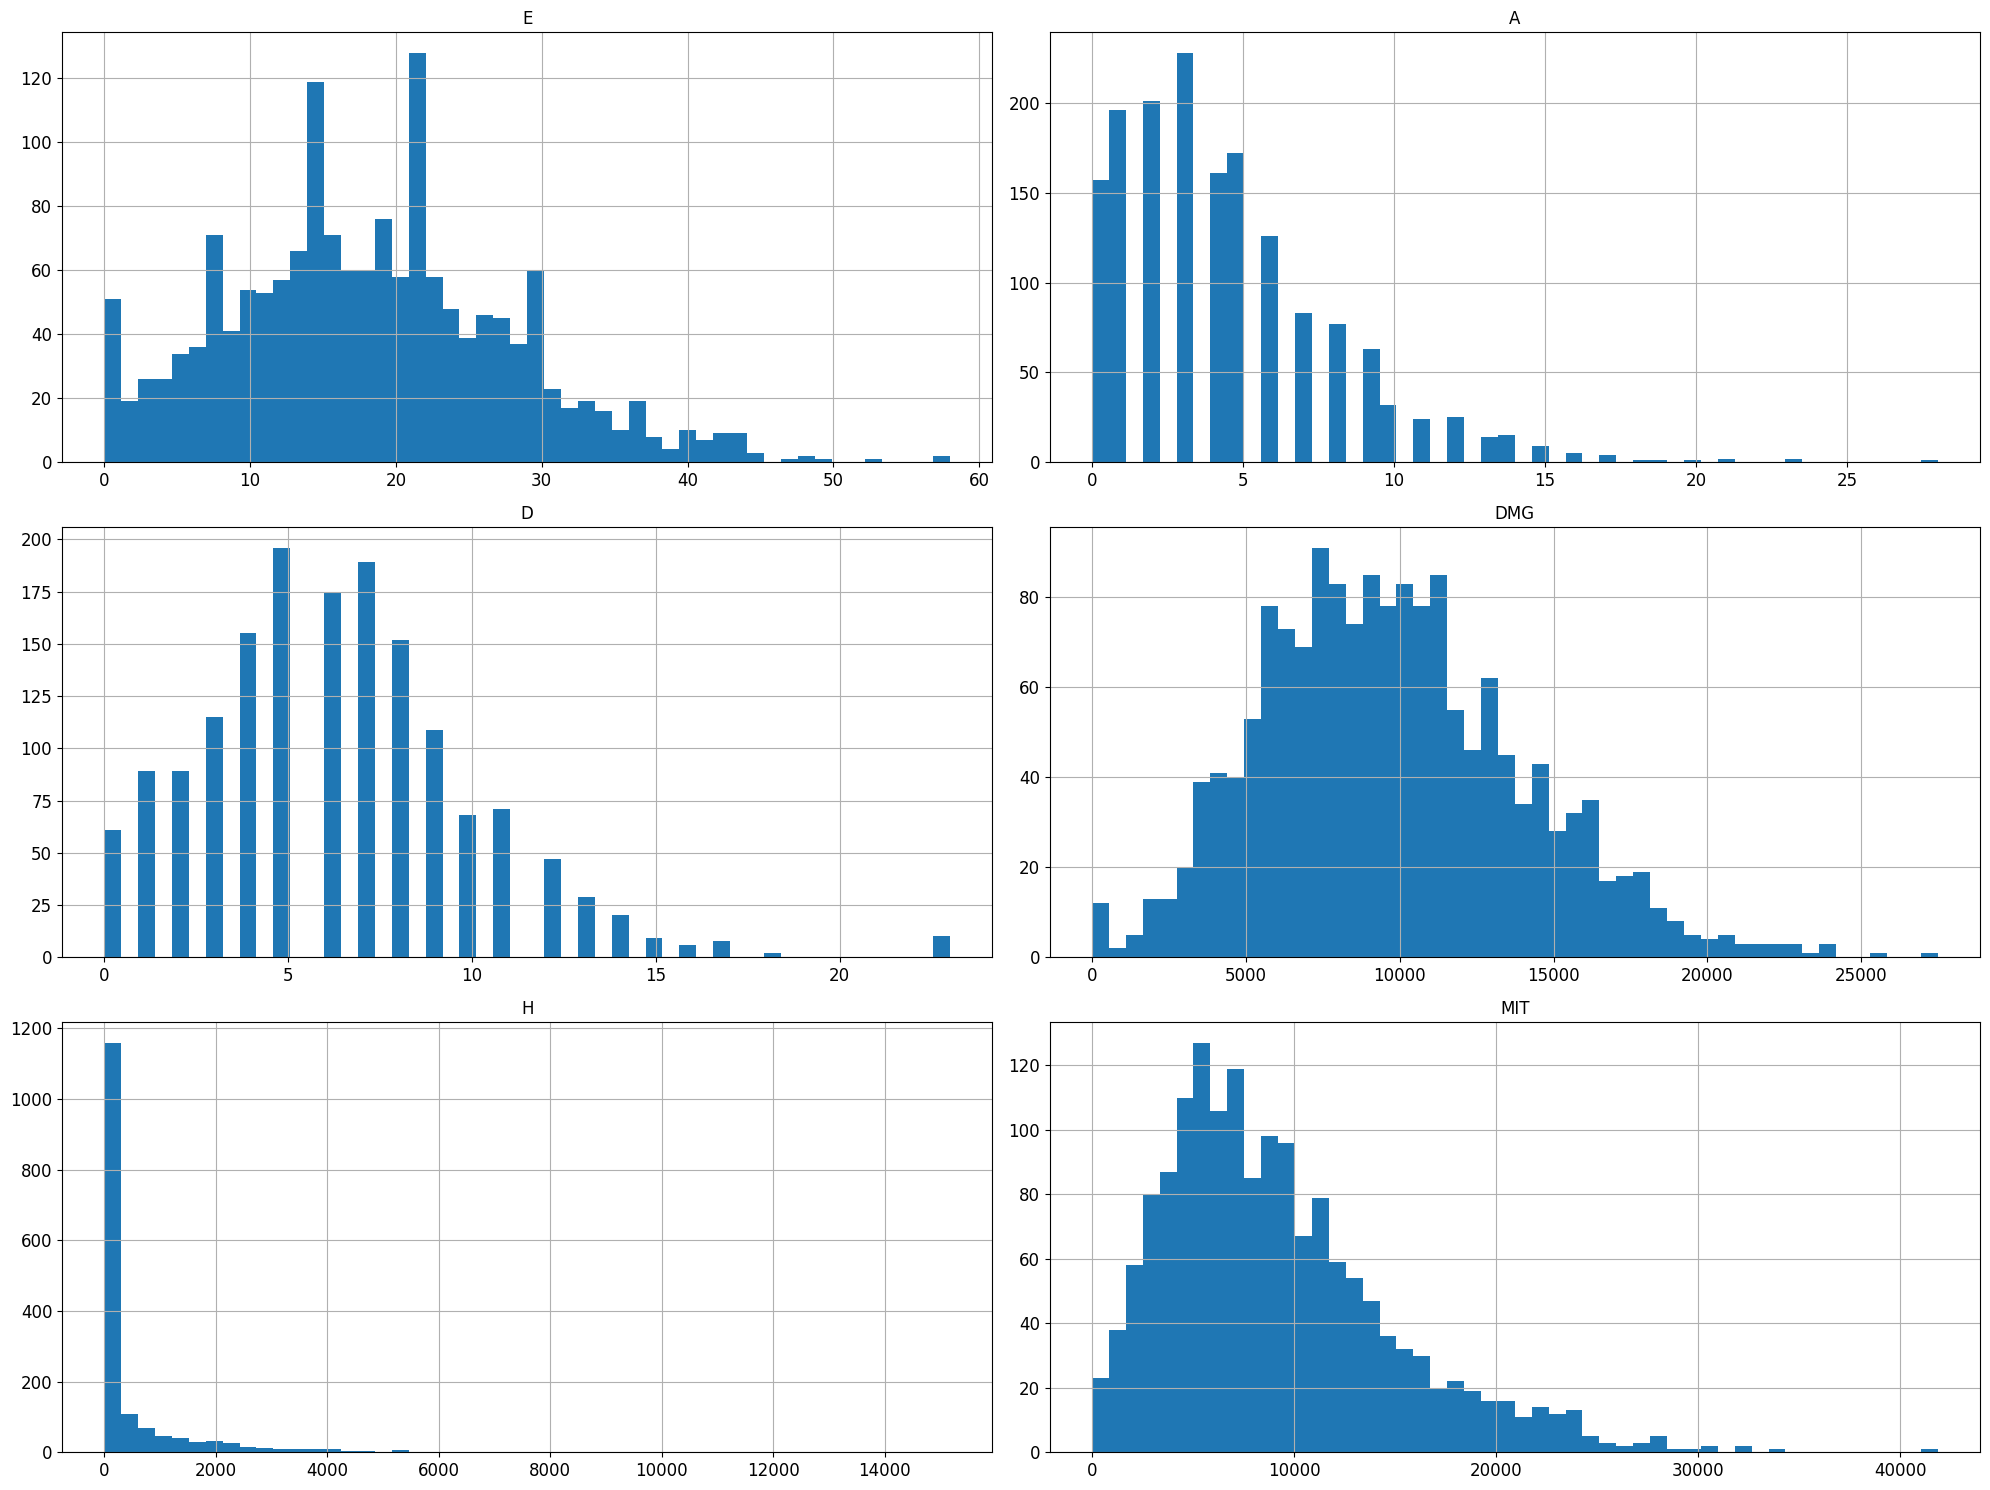

In [10]:
tank.hist(bins=50, figsize=(20, 15))
save_fig('tank_hist')
plt.show()

그림 저장:damage_hist


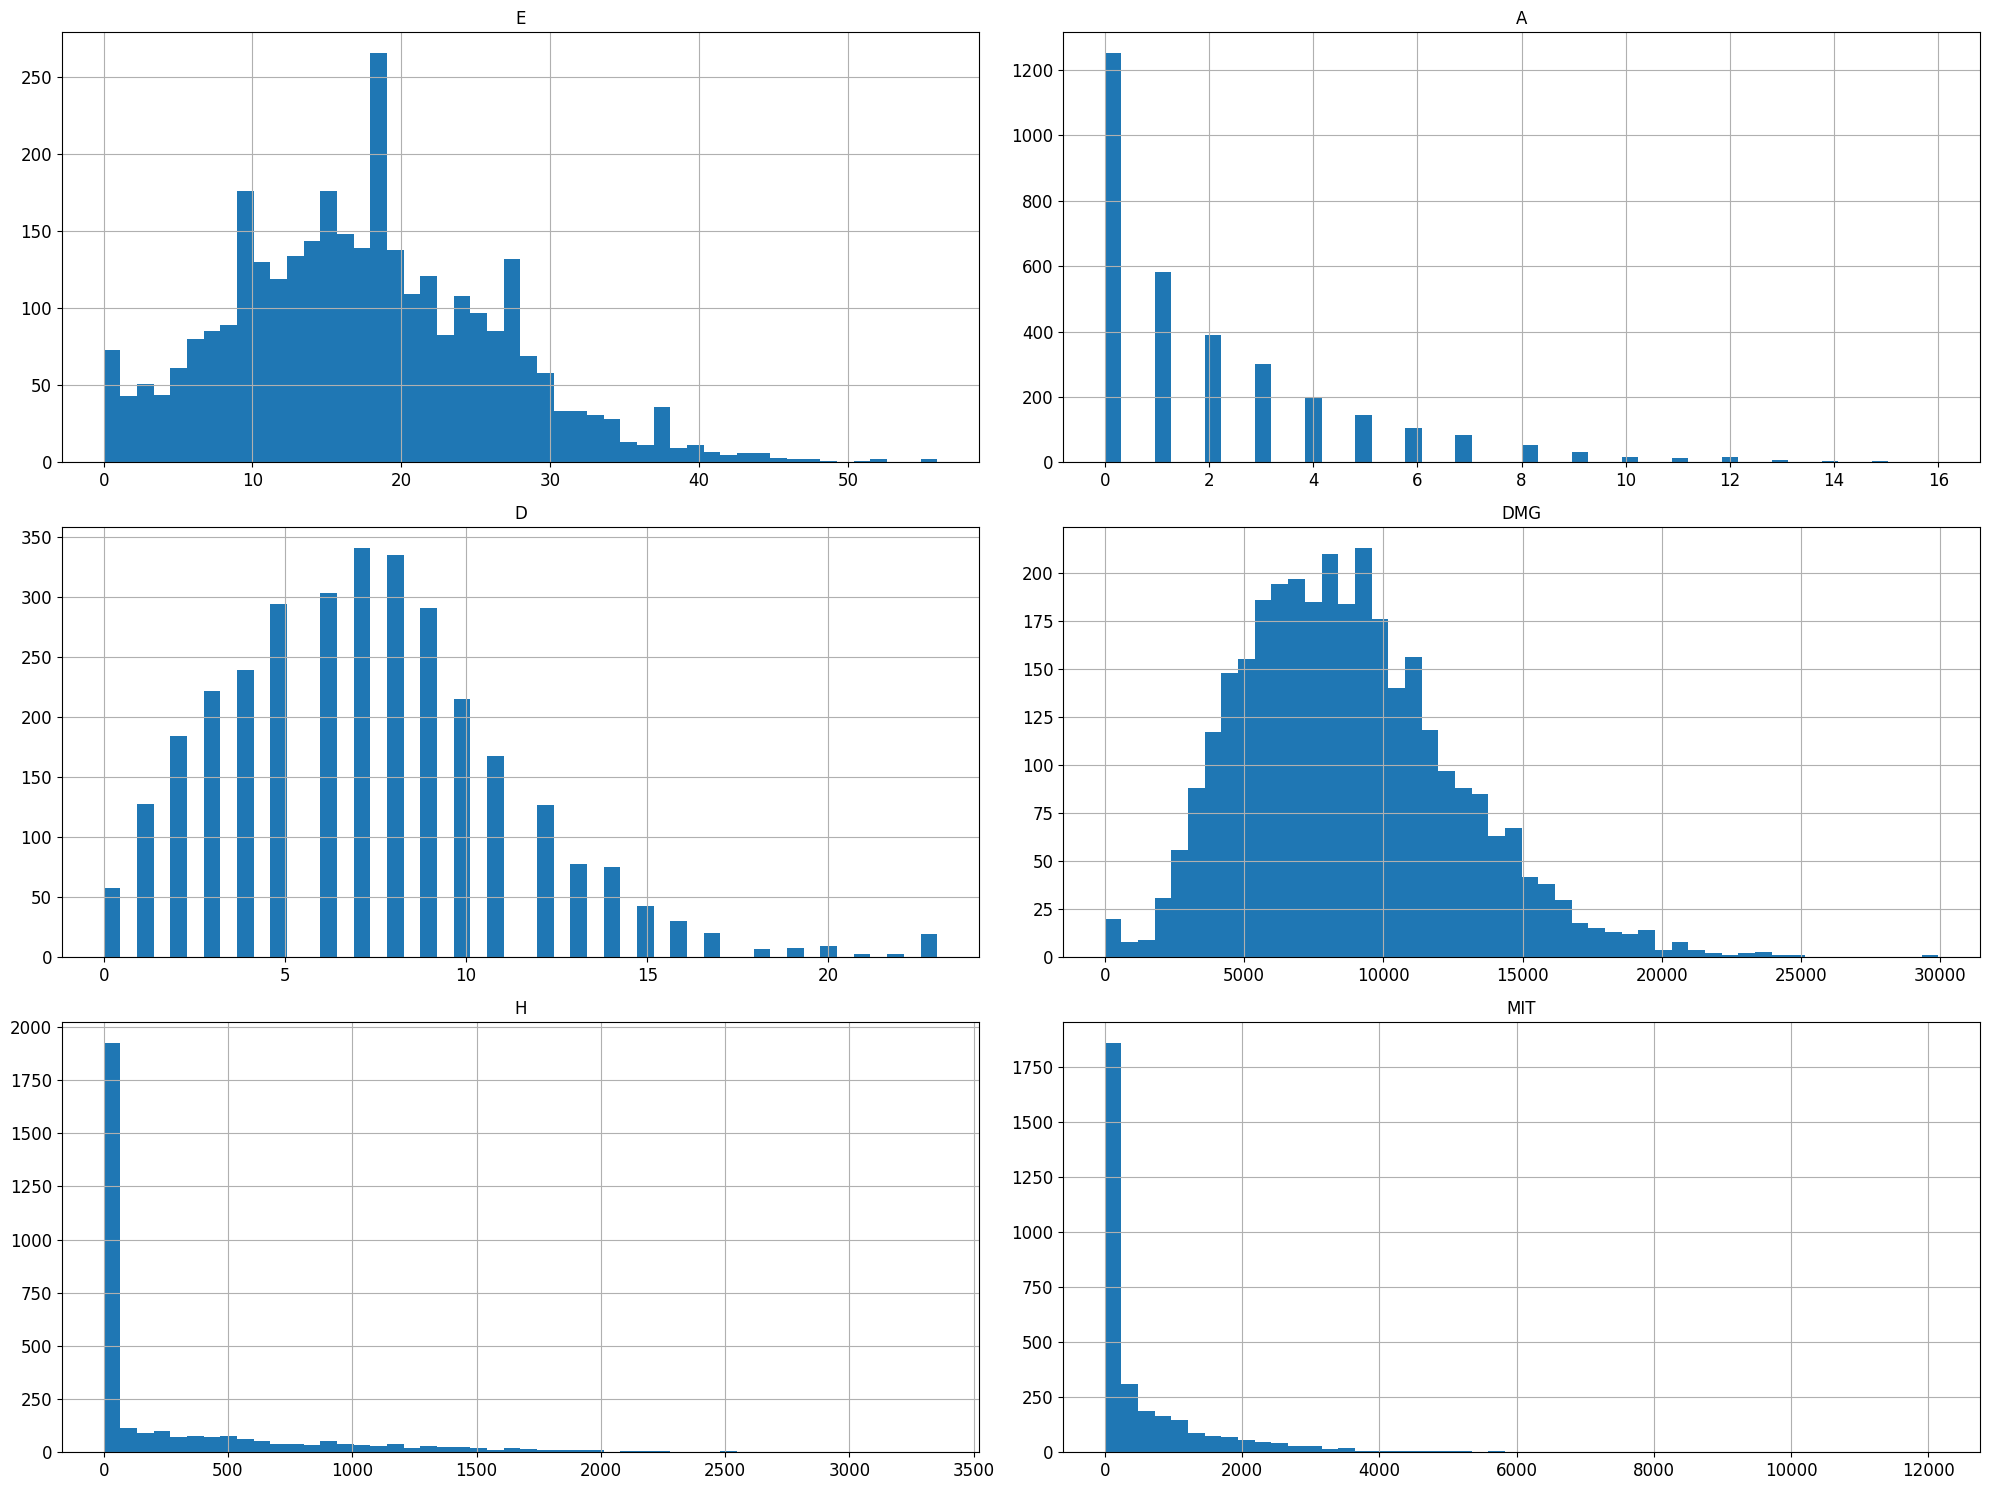

In [11]:
damage.hist(bins=50, figsize=(20, 15))
save_fig('damage_hist')
plt.show()

그림 저장:support_hist


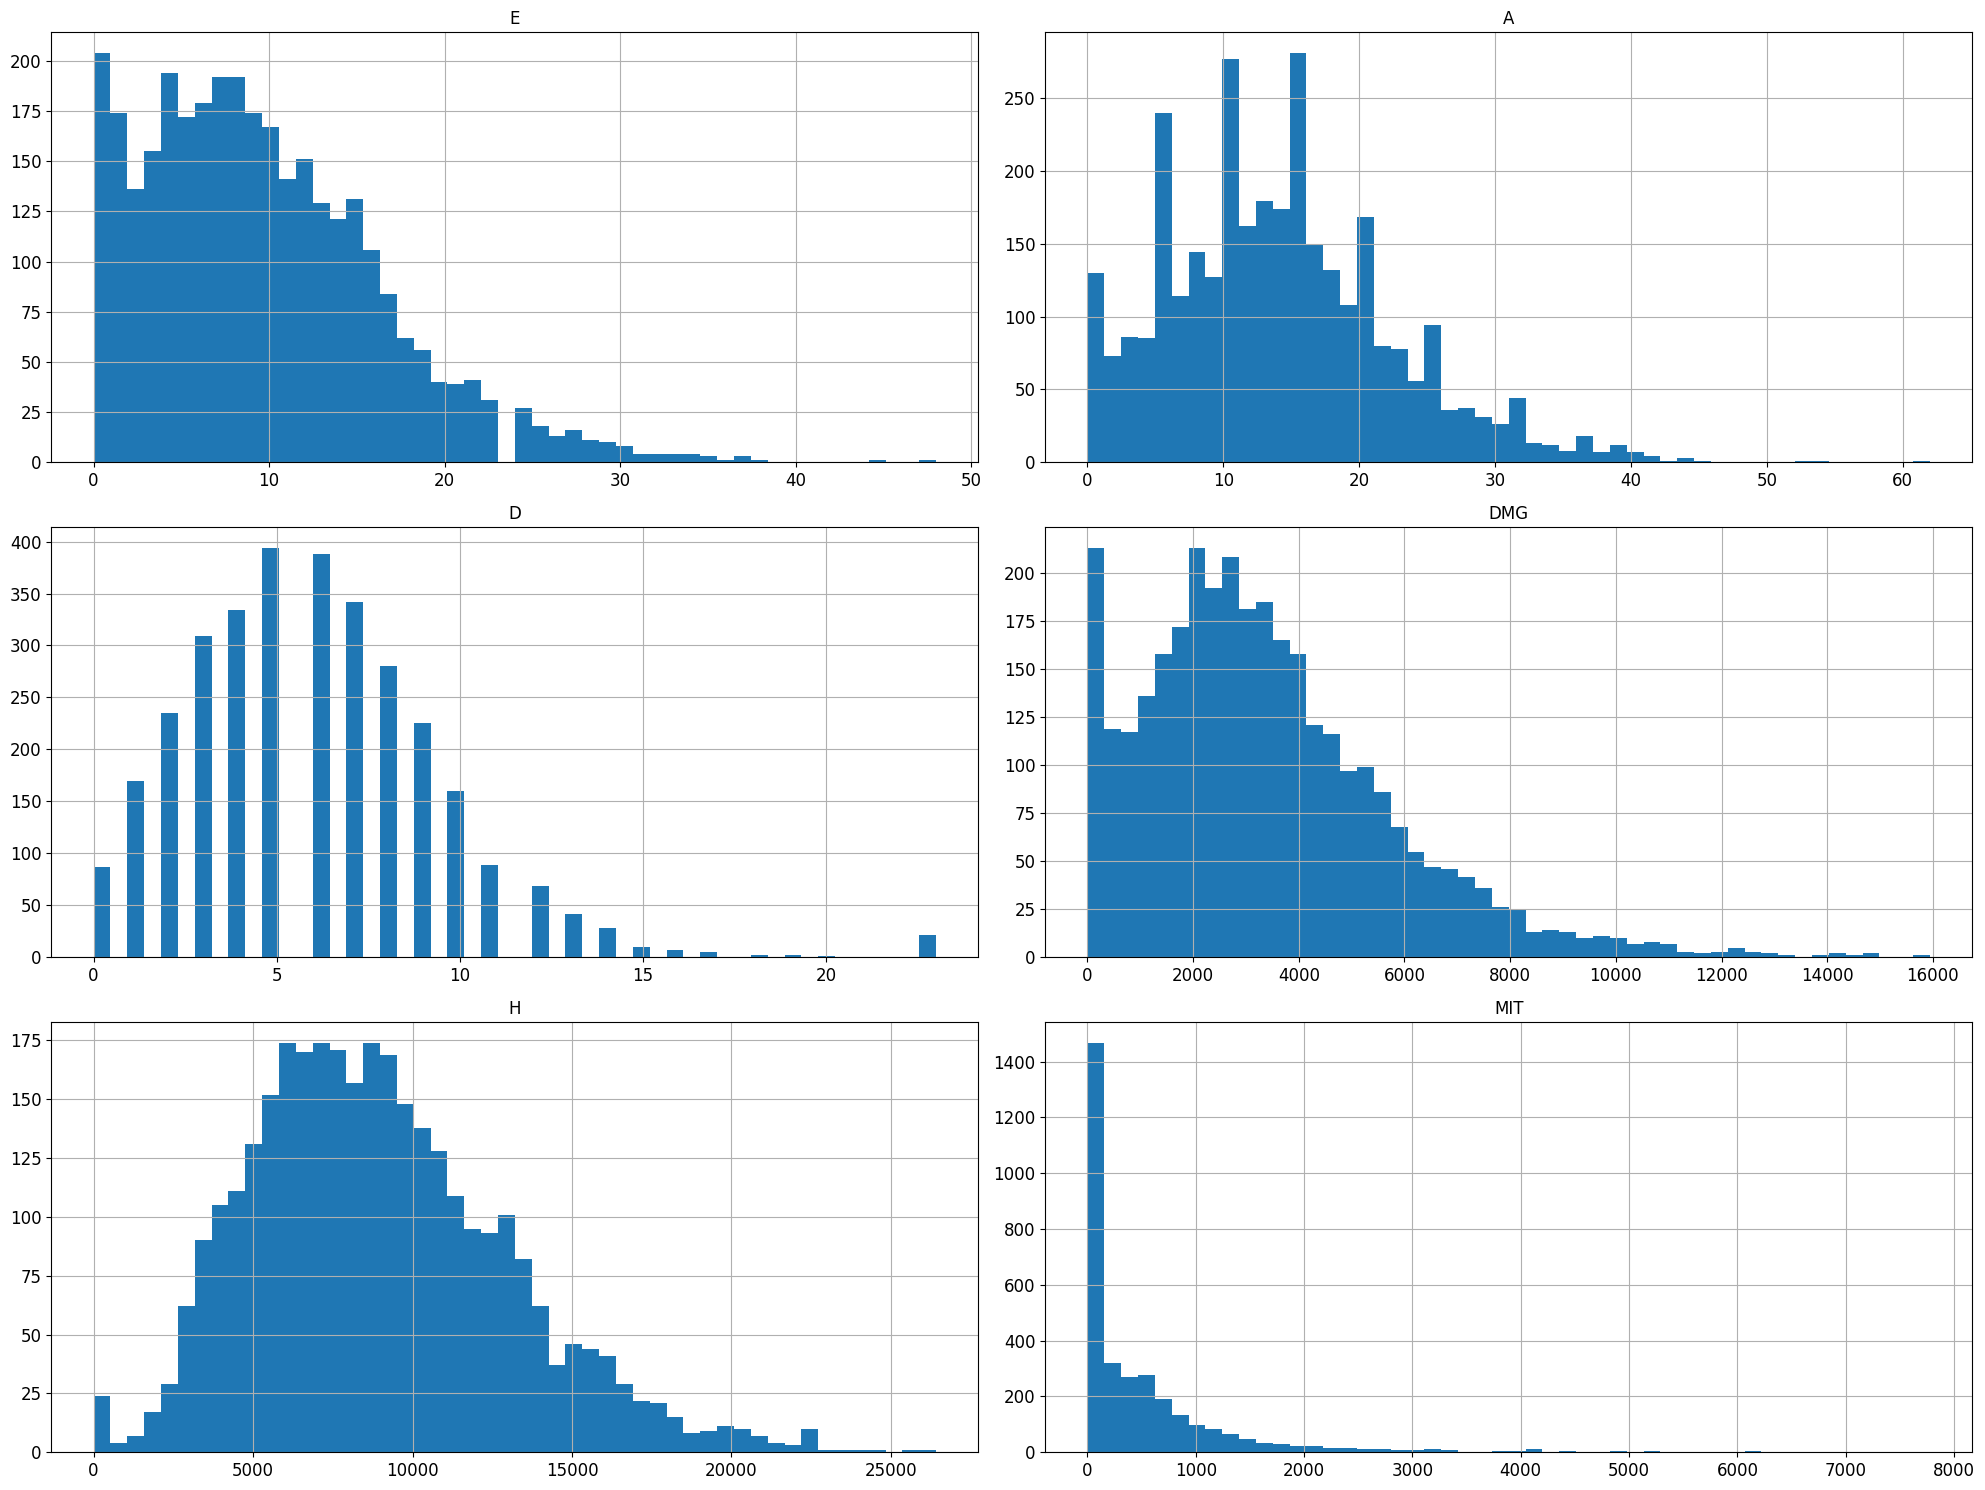

In [12]:
support.hist(bins=50, figsize=(20, 15))
save_fig('support_hist')
plt.show()

In [13]:
from sklearn import utils

scoreboards = scoreboards.loc[utils.shuffle(range(len(scoreboards.index) // players))]
scoreboards

E   A   D    DMG      H    MIT     GAME
445 0  58  14   6  19154      0  11785  VICTORY
    1  39   0   7  12908      0   2732  VICTORY
    2  48  16  12  20256     80    215  VICTORY
    3  35  29   9  10184   9898      0  VICTORY
    4   5  54   3    862  18798    897  VICTORY
...    ..  ..  ..    ...    ...    ...      ...
665 5   0   0  23      0      0      0   DEFEAT
    6   0   0  23      0      0      0   DEFEAT
    7   0   0  23      0      0      0   DEFEAT
    8   0   0  23      0      0      0   DEFEAT
    9   0   0  23      0      0      0   DEFEAT

[8000 rows x 7 columns]

In [14]:
X = scoreboards.drop('GAME', axis=1)
y = scoreboards['GAME'][::players].copy()

In [15]:
from sklearn import preprocessing

scaler = preprocessing.MinMaxScaler().fit(X)
joblib.dump(scaler, 'scaler.joblib')
X = pd.DataFrame(scaler.transform(X), X.index, X.columns)
X

E         A         D       DMG         H       MIT
445 0  1.000000  0.225806  0.260870  0.640131  0.000000  0.281608
    1  0.672414  0.000000  0.304348  0.431388  0.000000  0.065282
    2  0.827586  0.258065  0.521739  0.676960  0.003028  0.005138
    3  0.603448  0.467742  0.391304  0.340352  0.374655  0.000000
    4  0.086207  0.870968  0.130435  0.028808  0.711533  0.021434
...         ...       ...       ...       ...       ...       ...
665 5  0.000000  0.000000  1.000000  0.000000  0.000000  0.000000
    6  0.000000  0.000000  1.000000  0.000000  0.000000  0.000000
    7  0.000000  0.000000  1.000000  0.000000  0.000000  0.000000
    8  0.000000  0.000000  1.000000  0.000000  0.000000  0.000000
    9  0.000000  0.000000  1.000000  0.000000  0.000000  0.000000

[8000 rows x 6 columns]

In [16]:
features = X.shape[-1]
total_features = players * features
X = X.values.reshape(-1, total_features)
print(X.shape)
print(y.shape)

(800, 60)
(800,)


In [17]:
from sklearn import model_selection, linear_model

cv_iter = 1600
model_selection.cross_val_score(linear_model.LogisticRegressionCV(max_iter=cv_iter), X, y)

array([0.91875, 0.9    , 0.91875, 0.9125 , 0.9    ])

In [18]:
from sklearn import neighbors

radius = 2.
model_selection.cross_val_score(neighbors.RadiusNeighborsClassifier(radius), X, y)

array([0.65   , 0.63125, 0.69375, 0.575  , 0.625  ])

In [19]:
from sklearn import neural_network

classifier_iter = 3200
model_selection.cross_val_score(neural_network.MLPClassifier(max_iter=classifier_iter), X, y)

array([0.93125, 0.86875, 0.925  , 0.9    , 0.90625])

In [20]:
from sklearn import ensemble, svm, tree
import operator

estimators = (
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(n_jobs=-1),
    ensemble.ExtraTreesClassifier(n_jobs=-1),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(n_jobs=-1),
    ensemble.HistGradientBoostingClassifier(),
    linear_model.LogisticRegression(n_jobs=-1),
    linear_model.LogisticRegressionCV(max_iter=cv_iter, n_jobs=-1),
    linear_model.PassiveAggressiveClassifier(n_jobs=-1),
    linear_model.Perceptron(n_jobs=-1),
    linear_model.RidgeClassifier(),
    linear_model.RidgeClassifierCV(),
    linear_model.SGDClassifier(n_jobs=-1),
    neighbors.KNeighborsClassifier(n_jobs=-1),
    neighbors.RadiusNeighborsClassifier(radius, n_jobs=-1),
    neighbors.NearestCentroid(),
    neural_network.MLPClassifier(max_iter=classifier_iter),
    svm.LinearSVC(dual='auto'),
    svm.NuSVC(),
    svm.SVC(),
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier()
)
scores = [(estimator, model_selection.cross_val_score(estimator, X, y, n_jobs=-1).mean()) for estimator in estimators]
scores.sort(key=operator.itemgetter(1), reverse=True)
scores

/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[(ExtraTreesClassifier(n_jobs=-1), 0.9262500000000001),
 (NuSVC(), 0.91875),
 (SVC(), 0.91625),
 (KNeighborsClassifier(n_jobs=-1), 0.9125),
 (HistGradientBoostingClassifier(), 0.9099999999999999),
 (LogisticRegression(n_jobs=-1), 0.9099999999999999),
 (LogisticRegressionCV(max_iter=1600, n_jobs=-1), 0.9099999999999999),
 (RandomForestClassifier(n_jobs=-1), 0.9087500000000001),
 (LinearSVC(), 0.9087499999999998),
 (NearestCentroid(), 0.9037500000000002),
 (GradientBoostingClassifier(), 0.9),
 (RidgeClassifier(), 0.9),
 (RidgeClassifierCV(), 0.8975),
 (MLPClassifier(max_iter=3200), 0.8975),
 (AdaBoostClassifier(), 0.8800000000000001),
 (SGDClassifier(n_jobs=-1), 0.87625),
 (BaggingClassifier(n_jobs=-1), 0.875),
 (PassiveAggressiveClassifier(n_jobs=-1), 0.8737499999999999),
 (Perceptron(n_jobs=-1), 0.8674999999999999),
 (DecisionTreeClassifier(), 0.8387500000000001),
 (ExtraTreeClassifier(), 0.7825),
 (RadiusNeighborsClassifier(n_jobs=-1, radius=2.0), 0.635)]

In [21]:
defeats = len(defeat) // players


def find_file(index):
    index += 1
    if index <= defeats:
        return f'DEFEAT ({index})'
    else:
        index -= len(victory) // players
        return f'VICTORY ({index})'

In [42]:
for estimator, _ in scores:
    estimator = estimator.fit(X, y)
    if hasattr(estimator, 'feature_importances_'):
        importances = estimator.feature_importances_.reshape(-1, features)
        tanks, damages, supports = [0, 5], [1, 2, 6, 7], [3, 4, 8, 9]
        importances_tanks = importances[tanks].sum(0)
        importances_damages = importances[damages].sum(0)
        importances_supports = importances[supports].sum(0)
        importances[tanks] = importances_tanks / 2
        importances[damages] = importances_damages / 4
        importances[supports] = importances_supports / 4
        joblib.dump(importances, 'importances.joblib')

        titles = '처치', '도움', '죽음', '피해', '치유', '경감'

        print('**특성 중요도**')
        for importance, title in sorted(zip(importances.sum(0), titles), reverse=True):
            print(f'{title} (10인): {importance * 100:.2f}%')

        print('\n**역할 중요도**')
        for importance, title in sorted(
                zip((importances[tanks].sum(), importances[damages].sum(), importances[supports].sum()), ('돌격 (2인)', '공격 (4인)', '지원 (4인)')),
                reverse=True
        ):
            print(f'{title}: {importance * 100:.2f}%')

        print('\n**돌격 특성 중요도**')
        for importance, title in sorted(zip(importances_tanks, titles), reverse=True):
            print(f'{title} (2인): {importance * 100:.2f}%')

        print('\n**공격 특성 중요도**')
        for importance, title in sorted(zip(importances_damages, titles), reverse=True):
            print(f'{title} (4인): {importance * 100:.2f}%')

        print('\n**지원 특성 중요도**')
        for importance, title in sorted(zip(importances_supports, titles), reverse=True):
            print(f'{title} (4인): {importance * 100:.2f}%')

        break

**특성 중요도**
처치 (10인): 33.05%
죽음 (10인): 26.97%
도움 (10인): 19.70%
피해 (10인): 8.11%
치유 (10인): 6.09%
경감 (10인): 6.09%

**역할 중요도**
지원 (4인): 39.80%
공격 (4인): 34.81%
돌격 (2인): 25.39%

**돌격 특성 중요도**
처치 (2인): 9.81%
죽음 (2인): 7.51%
도움 (2인): 3.77%
피해 (2인): 1.95%
경감 (2인): 1.32%
치유 (2인): 1.03%

**공격 특성 중요도**
처치 (4인): 15.34%
죽음 (4인): 8.36%
도움 (4인): 3.38%
피해 (4인): 3.29%
치유 (4인): 2.23%
경감 (4인): 2.21%

**지원 특성 중요도**
도움 (4인): 12.55%
죽음 (4인): 11.10%
처치 (4인): 7.90%
피해 (4인): 2.87%
치유 (4인): 2.83%
경감 (4인): 2.56%


In [43]:
defeats = defeat.index.stop
for i in range(defeats - 10, defeats - 101, -players):
    defeat_i = defeat[i:i + players]
    print(f'DEFEAT ({i // players + 1})')
    print(defeat_i)
    contributions = scaler.transform(defeat_i.drop(['GAME'], axis=1))
    contributions[:, 2] = 1 - contributions[:, 2]
    contributions *= importances
    contributions = contributions.sum(1)
    contributions[tanks] *= 2 / contributions[tanks].sum()
    contributions[damages] *= 4 / contributions[damages].sum()
    contributions[supports] *= 4 / contributions[supports].sum()
    print(f'TEAM 1:', end='')
    for contribution in contributions[:5]:
        print(f' {contribution:.2f}', end='')
    print(f'\nTEAM 2:', end='')
    for contribution in contributions[5:]:
        print(f' {contribution:.2f}', end='')
    print('\n')

DEFEAT (400)
       E   A  D    DMG      H    MIT     GAME
3990  19   4  7  13416      0  12891   DEFEAT
3991  17   5  7   9946      0     66   DEFEAT
3992  15   0  9   9044      0   1528   DEFEAT
3993  15   7  6   6262   9478      0   DEFEAT
3994   1  16  4    327  11754   1473   DEFEAT
3995  14   6  4  10815      0  10085  VICTORY
3996  18   1  7  11315    358     66  VICTORY
3997  17   0  9   9601    351   1048  VICTORY
3998  14  16  4   3213  10639    347  VICTORY
3999  14  13  5   4496  13115      0  VICTORY
TEAM 1: 1.00 1.05 0.91 0.92 0.96
TEAM 2: 1.00 1.07 0.97 1.09 1.04

DEFEAT (399)
       E   A   D    DMG     H    MIT     GAME
3980  13   0  11  10020     0  16678   DEFEAT
3981  12   0  13   7309   309      0   DEFEAT
3982  11   0  14  10571    99   1944   DEFEAT
3983   7   8  12   3631  5663   1631   DEFEAT
3984   8   6  12   3752  8422    535   DEFEAT
3985  40   8   4  14349     0  11425  VICTORY
3986  22   4   6   9873   331      0  VICTORY
3987  30   0   7  12102   664    

In [44]:
victorys = victory.index.stop
for i in range(victorys - 10, victorys - 101, -players):
    victory_i = victory[i:i + players]
    print(f'VICTORY ({i // players + 1})')
    print(victory_i)
    contributions = scaler.transform(victory_i.drop(['GAME'], axis=1))
    contributions[:, 2] = 1 - contributions[:, 2]
    contributions *= importances
    contributions = contributions.sum(1)
    contributions[tanks] *= 2 / contributions[tanks].sum()
    contributions[damages] *= 4 / contributions[damages].sum()
    contributions[supports] *= 4 / contributions[supports].sum()
    print(f'TEAM 1:', end='')
    for contribution in contributions[:5]:
        print(f' {contribution:.2f}', end='')
    print(f'\nTEAM 2:', end='')
    for contribution in contributions[5:]:
        print(f' {contribution:.2f}', end='')
    print('\n')

VICTORY (400)
       E   A   D    DMG      H    MIT     GAME
3990  18   4   9  14380    209  27023  VICTORY
3991  25   2   7  11881      0   1075  VICTORY
3992  22   6  12  13375     11   2384  VICTORY
3993  15  14   9   5829  12206   2650  VICTORY
3994  11  18   9   4230  14181   1143  VICTORY
3995  27   7   8  15849      0  15230   DEFEAT
3996  29   3   8  16346   2157      0   DEFEAT
3997  26   1   8  12135      0    750   DEFEAT
3998  19  21   8   5391  12042   4184   DEFEAT
3999  13  18  12   3535  10878    641   DEFEAT
TEAM 1: 0.92 1.02 0.86 0.98 0.99
TEAM 2: 1.08 1.12 1.01 1.15 0.88

VICTORY (399)
       E   A  D   DMG     H   MIT     GAME
3980  19   4  0  7502     0  3324  VICTORY
3981  15   1  3  5674     0    51  VICTORY
3982  12   4  5  3063     0     0  VICTORY
3983   6  12  2  1418  5489    57  VICTORY
3984   7  11  1  2022  5873     0  VICTORY
3985   3   0  6  6496     0  4758   DEFEAT
3986   5   1  7  5866     0     0   DEFEAT
3987   6   0  6  3839     0     0   DEFEAT
3

In [25]:
from tensorflow.keras import backend, layers
from tensorflow import keras

backend.clear_session()
model = keras.Sequential()
model.add(keras.Input((total_features,)))
model.add(layers.Dense(300, 'relu'))
model.add(layers.Dense(100, 'relu'))
model.add(layers.Dense(1, 'sigmoid'))
model.summary()

2024-11-13 10:29:08.115191: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-13 10:29:08.324671: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-13 10:29:08.387719: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-13 10:29:08.728684: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
I0000 00:00:1731493752.934481    2935 cuda_executor.c

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 300)            │        18,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        30,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 48,501 (189.46 KB)

 Trainable params: 48,501 (189.46 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
from tensorflow.keras import optimizers, callbacks

model.compile('sgd', 'binary_crossentropy', metrics=['accuracy'])
transform = preprocessing.LabelEncoder().fit_transform(y)
stopping = callbacks.EarlyStopping(patience=10, restore_best_weights=True)
history = model.fit(
    X,
    transform,
    epochs=256,
    callbacks=[stopping],
    validation_split=.25
)
history.history['val_loss'][-11], history.history['val_accuracy'][-11]

Epoch 1/256


I0000 00:00:1731493753.984378    3695 service.cc:146] XLA service 0x7f96040067f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731493753.984506    3695 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti, Compute Capability 8.6
2024-11-13 10:29:14.068958: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-13 10:29:14.301937: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-11-13 10:29:15.424053: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_37', 36 bytes spill stores, 36 bytes spill loads

2024-11-13 10:29:15.811062: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in funct

 1/19 ━━━━━━━━━━━━━━━━━━━━ 51s 3s/step - accuracy: 0.3750 - loss: 0.7016

I0000 00:00:1731493756.505336    3695 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2024-11-13 10:29:17.471990: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_277', 20 bytes spill stores, 20 bytes spill loads

2024-11-13 10:29:17.608634: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_277', 16 bytes spill stores, 16 bytes spill loads



19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 193ms/step - accuracy: 0.3581 - loss: 0.7019 - val_accuracy: 0.4400 - val_loss: 0.6990
Epoch 2/256
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5166 - loss: 0.6899 - val_accuracy: 0.4800 - val_loss: 0.6896
Epoch 3/256
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5827 - loss: 0.6766 - val_accuracy: 0.5600 - val_loss: 0.6805
Epoch 4/256
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6335 - loss: 0.6686 - val_accuracy: 0.6450 - val_loss: 0.6721
Epoch 5/256
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7143 - loss: 0.6560 - val_accuracy: 0.7300 - val_loss: 0.6626
Epoch 6/256
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7504 - loss: 0.6516 - val_accuracy: 0.7600 - val_loss: 0.6537
Epoch 7/256
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8028 - loss: 0.6427 - val_accuracy: 0.7900 - val_loss: 0.6453
Epoch 8/256
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8167 - loss: 0.6342 - val_accuracy: 0.8300 - val_loss: 0

(0.26970070600509644, 0.8999999761581421)